In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rosbag import Bag

import os
try: data_dir = data_dir = os.path.realpath(os.path.join(os.path.dirname(__file__), '../data'))
except NameError: data_dir = os.path.realpath(os.path.join(globals()['_dh'][0], '../data'))


In [2]:
traject_filename = os.path.join(data_dir, 'trajectory_with_imu.txt')
print(f'reading trajectory from:\n\t{traject_filename}')

trajectory = []
start_time = None
timestamp = 0

with open(traject_filename) as f:
    x, y, z = [], [], []
    in_points = False
    in_stamp = False
    for line in f:
        if 'stamp' in line:
            in_stamp = True
        elif 'frame_id' in line:
            in_stamp = False
        if in_stamp:
            if 'nsecs' in line:
                nsec = float(line.split(':')[-1])
                timestamp += nsec * 1e-9
                if not start_time:
                    start_time = timestamp
            elif 'secs' in line:
                timestamp = float(line.split(':')[-1])

        # find the start of the section that contains all point
        if 'points' in line:
            in_points = True
            # reset
            x, y, z = [], [], []
        elif 'color' in line:
            in_points = False
        
        if in_points:
            # get the x and y values
            if 'x' in line:
                x.append(float(line.split(':')[-1]))
            if 'y' in line:
                y.append(float(line.split(':')[-1]))
            if 'z' in line:
                z.append(float(line.split(':')[-1]))

times = np.linspace(start_time, timestamp, len(x))
trajectory = pd.DataFrame(zip(times, x, y, z), columns=['timestamp', 'x', 'y', 'z'])

trajectory['timestamp'] = pd.to_datetime(trajectory['timestamp']*1e9, unit='ns')
trajectory = trajectory.set_index('timestamp')

trajectory

reading trajectory from:
	/home/jelmer/shared_data/60 MSc Robotics/Perception Cognition Navigation/Assignments/partc/RPCN/data/trajectory_with_imu.txt


,x,y,z
timestamp,,,
2022-11-30 10:20:54.066980864,0.000000,0.000000,0.0
2022-11-30 10:20:54.101771776,-0.000323,-0.000089,0.0
2022-11-30 10:20:54.136562944,0.003223,0.000491,0.0
2022-11-30 10:20:54.171354112,0.008340,0.002151,0.0
2022-11-30 10:20:54.206145280,0.002694,0.001345,0.0
...,...,...,...
2022-11-30 10:22:55.661821696,0.266141,0.287691,0.0
2022-11-30 10:22:55.696612864,0.266350,0.281892,0.0
2022-11-30 10:22:55.731403776,0.268150,0.275392,0.0


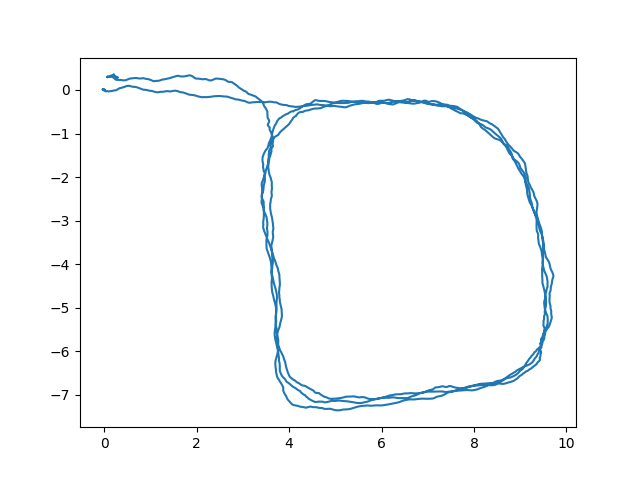

In [3]:
plt.figure()
plt.plot(trajectory['x'], trajectory['y'])
plt.show()

In [4]:
bag_filename = os.path.join(data_dir, 'test3.bag')
print(f'reading lidar scan data from:\n\t{bag_filename}')

def get_xy(msg):
    x = np.zeros(shape=[len(msg.ranges)])
    y = np.zeros(shape=[len(msg.ranges)])
    for nr, dist in enumerate(msg.ranges):
        # Lidar returns angle and distance. translate to xy positions
        angle = msg.angle_min + msg.angle_increment * nr
        x[nr] = dist * np.sin(angle)
        y[nr] = dist * np.cos(angle)
    return x, y

scan0 = []
scan1 = []
for topic, msg, t in Bag(bag_filename):
    if topic == '/scan0':
        scan0.append( get_xy(msg) )
    elif topic == '/scan1':
        scan1.append( get_xy(msg) )

print(f'Lidar0 has {len(scan0)} scans, each with {len(scan0[0][0])} (x,y) coordinates')
print(f'Lidar1 has {len(scan1)} scans, each with {len(scan1[0][0])} (x,y) coordinates')

reading lidar scan data from:
	/home/jelmer/shared_data/60 MSc Robotics/Perception Cognition Navigation/Assignments/partc/RPCN/data/test3.bag
Lidar0 has 4001 scans, each with 1081 (x,y) coordinates
Lidar1 has 4108 scans, each with 1081 (x,y) coordinates


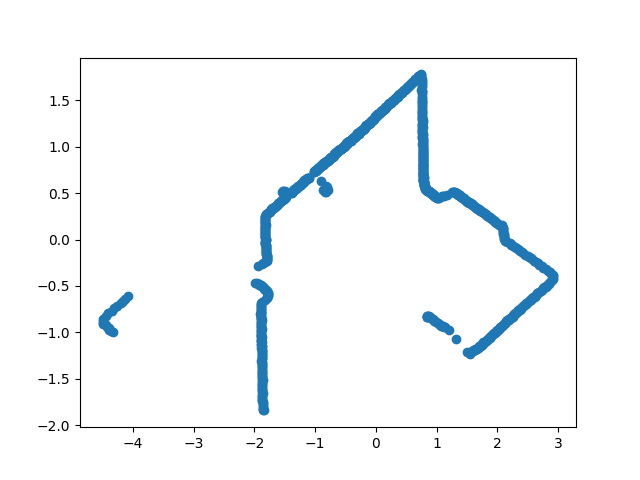

In [5]:
plt.figure()
plt.scatter(scan0[-1][0], scan0[-1][1])
plt.show()

In [6]:
print('rotating and translating the scan data to the body frame')

# homogeneous transformations from lidar to body frame
scan0_to_body = np.array([
    [-0.17536324, -0.88242307, -0.43655155,        -0.31542722],
    [ 0.56780261,  0.27159240, -0.77706999,        -0.14370224],
    [ 0.80426857, -0.38414462,  0.45341480,        -0.20138267],
    [ 0.0,         0.0,         0.0,                1.0       ]])

scan1_to_body = np.array([
    [ 0.03916269,  0.87931668,  0.47462455,         0.31813329],
    [-0.53352080,  0.42001741, -0.73412596,        -0.14264865],
    [-0.84487978, -0.22447172,  0.48558275,        -0.19282741],
    [ 0.0,         0.0,         0.0,                1.0       ]])


scan0_rot = []
# apply transformation and translation to each scan
for x, y in scan0:
    # make array of homogeneous coordinates. Z is also 0
    transf_points = np.zeros(shape=[4, len(x)])
    transf_points[0, :] = x
    transf_points[1, :] = y

    # apply homogenous transformation on points
    transf_points = np.dot(scan0_to_body, transf_points)

    # remove 4th value and transpose
    transf_points = transf_points[0:3, :].T
    scan0_rot.append(transf_points)


scan1_rot = []
# apply transformation and translation to each scan
for x, y in scan1:
    # make array of homogeneous coordinates. Z is also 0
    transf_points = np.zeros(shape=[4, len(x)])
    transf_points[0, :] = x
    transf_points[1, :] = y

    # apply homogenous transformation on points
    transf_points = np.dot(scan1_to_body, transf_points)

    # remove 4th value and transpose
    transf_points = transf_points[0:3, :].T
    scan1_rot.append(transf_points)


rotating and translating the scan data to the body frame


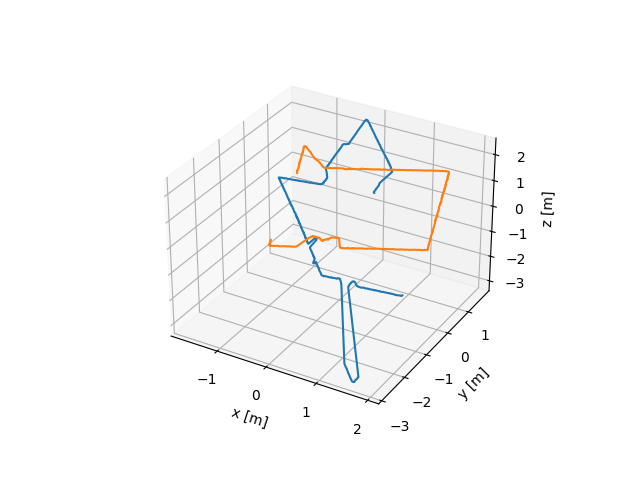

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(scan0_rot[-1][:, 0], scan0_rot[-1][:, 1], scan0_rot[-1][:, 2], label='scan0')
ax.plot(scan1_rot[-1][:, 0], scan1_rot[-1][:, 1], scan1_rot[-1][:, 2], label='scan1')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

In [8]:
print("combining scan data and trajectory into a 3d pointcloud")

scan = scan0_rot

# resample the trajectory so that each position corresponds to scan
traject_duration = trajectory.index[-1] - trajectory.index[0]
scan_period = traject_duration / len(scan)
print(f'trajectory has {len(trajectory)} point. there are {len(scan)} scans')
print(f"\tresampling {traject_duration} trajectory with sampling period of {scan_period}")
traject = trajectory.resample(scan_period).mean().interpolate(method='linear')

transformation = np.identity(4)
pointcloud = []
for scan_points, row in zip(scan, traject.iterrows()):
    timestamp, (x, y, z) = row
    # somehow calculate tranformations based on trajectory, then apply on the scan points
    print(timestamp, x, y, z, scan_points.mean(axis=0))
    pass



combining scan data and trajectory into a 3d pointcloud
trajectory has 3500 point. there are 4001 scans
	resampling 0 days 00:02:01.734005248 trajectory with sampling period of 0 days 00:00:00.030425894
2022-11-30 10:20:54.042705586 0.0 0.0 0.0 [-0.39044427  0.09174661 -0.2186861 ]
2022-11-30 10:20:54.073131480 -0.0003230037834581683 -8.861074193917017e-05 0.0 [-0.39028794  0.09185478 -0.21835021]
2022-11-30 10:20:54.103557374 0.0014499288990505888 0.00020136859258878729 0.0 [-0.38920286  0.09064154 -0.21938475]
2022-11-30 10:20:54.133983268 0.003222861581559346 0.0004913479271167448 0.0 [-0.38947556  0.09082845 -0.21932697]
2022-11-30 10:20:54.164409162 0.008340134311669304 0.0021506467834086908 0.0 [-0.39092953  0.09180259 -0.21905738]
2022-11-30 10:20:54.194835056 0.002693743074592815 0.0013451932316378347 0.0 [-0.39071351  0.09194076 -0.21861259]
2022-11-30 10:20:54.225260950 -0.005373219399790335 0.0012617092793514406 0.0 [-0.39122916  0.09214521 -0.21875868]
2022-11-30 10:20:54.2